In [ ]:
# This is predecessor code for reading in FITS images and doing other stuff
# for analysis pertinent to test FPR 0987

# Created 2021 July 6 by E.S.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import scipy.signal
from itertools import combinations

%matplotlib inline

In [2]:
stem = "./data/fpr_0987/pupil_shift_images/"

In [3]:
file_list_pupil = np.sort(glob.glob(stem + "*fits"))

In [4]:
def bad_pix(input_array):
    
    output_array = np.copy(input_array)
    # define bad pixels as anything higher than 22k
    bool_ind = input_array > 22000
    output_array[bool_ind] = np.median(input_array)
    
    return output_array

In [5]:
# read in first image as a baseline

hdul = fits.open(file_list_pupil[0])
baseline_image = bad_pix(hdul[0].data)

0.14590176331783836
0.12277332444949948
0.13705436432556317
0.14589083730939315
0.12342106114715394
0.1243849936888018
0.1442659315268668
0.13716555658481766
0.16115414048170412
0.14718062867133033
0.13457160376978036


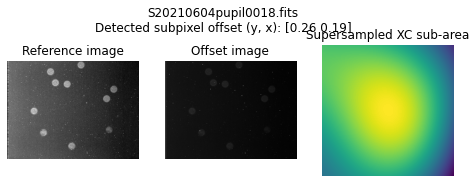

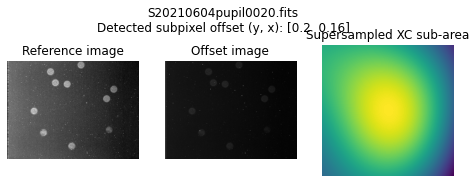

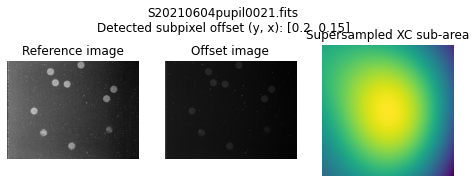

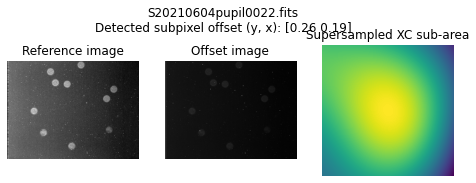

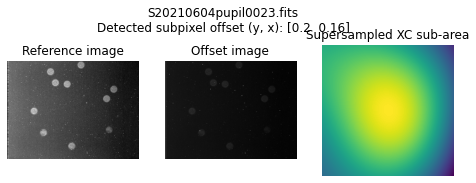

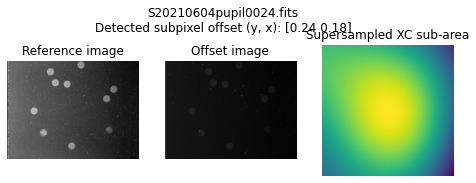

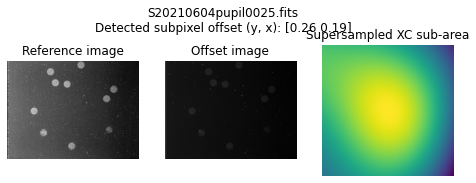

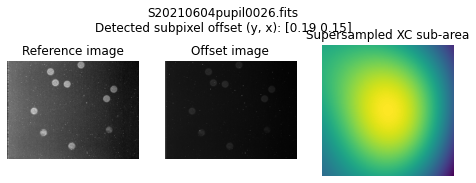

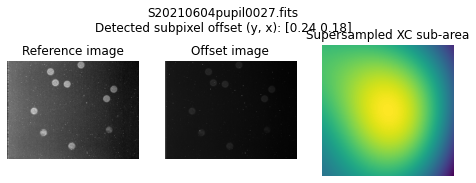

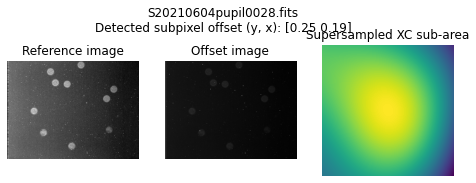

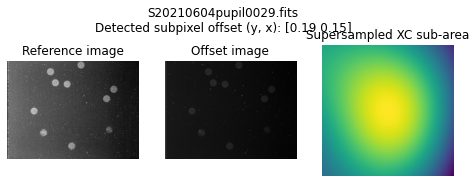

In [24]:
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

# initialize dictionary
keyDict = {"file_name","x_off_pix","y_off_pix","error_pix"}
dict_offsets = dict([(key, []) for key in keyDict])

for i in range(0,len(file_list_pupil)):

    hdul = fits.open(file_list_pupil[i])
    comparison_image = hdul[0].data
    
    offset_image = comparison_image

    # Code shamelessly cribbed from 
    # https://scikit-image.org/docs/0.13.x/auto_examples/transform/plot_register_translation.html

    # subpixel precision
    shift, error, diffphase = register_translation(baseline_image, offset_image, 100)
    print(error)

    fig = plt.figure(figsize=(8, 3))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
    ax3 = plt.subplot(1, 3, 3)

    ax1.imshow(baseline_image, cmap='gray')
    ax1.set_axis_off()
    ax1.set_title('Reference image')

    ax2.imshow(offset_image.real, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title('Offset image')

    # Calculate the upsampled DFT, again to show what the algorithm is doing
    # behind the scenes.  Constants correspond to calculated values in routine.
    # See source code for details.
    image_product = np.fft.fft2(baseline_image) * np.fft.fft2(offset_image).conj()
    cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
    ax3.imshow(cc_image.real)
    ax3.set_axis_off()
    ax3.set_title("Supersampled XC sub-area")
    plt.suptitle(os.path.basename(file_list_pupil[i])+"\nDetected subpixel offset (y, x): {}".format(shift))

    plt.savefig("pupil_shift_"+str(int(i))+".png", dpi=400)

    # update the dictionary
    dict_offsets["file_name"].append(os.path.basename(file_list_pupil[i]))
    dict_offsets["x_off_pix"].append(shift[1])
    dict_offsets["y_off_pix"].append(shift[0])
    dict_offsets["error_pix"].append(error)

In [26]:
# convert to DataFrame

df_offsets = pd.DataFrame.from_dict(dict_offsets)

In [27]:
# calculate micron offsets

# pixel scale is 14.1 mas/pix
# plate scale is 1.610 arcsec/mm

conv_factor = 14.1*np.divide(1.,10**3)*np.divide(1.,1.61)*10**3
df_offsets["x_off_um"] = np.multiply(df_offsets["x_off_pix"],conv_factor)
df_offsets["y_off_um"] = np.multiply(df_offsets["y_off_pix"],conv_factor)       
df_offsets["error_um"] = np.multiply(df_offsets["error_pix"],conv_factor)  

In [28]:
df_offsets

,y_off_pix,file_name,x_off_pix,error_pix,x_off_um,y_off_um,error_um
0,0.26,S20210604pupil0018.fits,0.19,0.145902,1.663975,2.277019,1.277773
1,0.20,S20210604pupil0020.fits,0.16,0.122773,1.401242,1.751553,1.075220
2,0.20,S20210604pupil0021.fits,0.15,0.137054,1.313665,1.751553,1.200290
3,0.26,S20210604pupil0022.fits,0.19,0.145891,1.663975,2.277019,1.277678
4,0.20,S20210604pupil0023.fits,0.16,0.123421,1.401242,1.751553,1.080893
5,0.24,S20210604pupil0024.fits,0.18,0.124385,1.576398,2.101863,1.089334
6,0.26,S20210604pupil0025.fits,0.19,0.144266,1.663975,2.277019,1.263447
7,0.19,S20210604pupil0026.fits,0.15,0.137166,1.313665,1.663975,1.201264
8,0.24,S20210604pupil0027.fits,0.18,0.161154,1.576398,2.101863,1.411350
9,0.25,S20210604pupil0028.fits,0.19,0.147181,1.663975,2.189441,1.288973


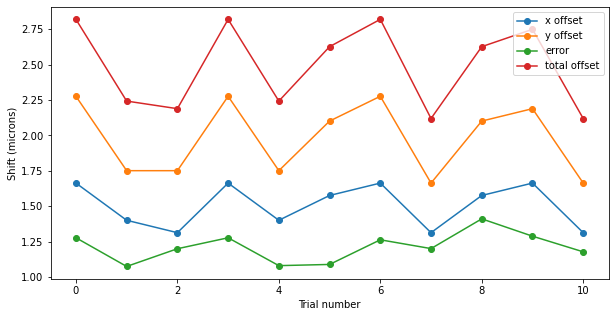

In [32]:
fig = plt.figure(figsize=(10,5))
plt.plot(df_offsets["x_off_um"], marker="o", label="x offset")
plt.plot(df_offsets["y_off_um"], marker="o", label="y offset")
plt.plot(df_offsets["error_um"], marker="o", label="error")
plt.plot(np.sqrt(np.power(df_offsets["x_off_um"],2)+np.power(df_offsets["y_off_um"],2)), marker="o", label="total offset")
plt.xlabel("Trial number")
plt.ylabel("Shift (microns)")
plt.legend()
plt.savefig("junk_plot.pdf")